In [18]:
import os
import random
from PIL import Image
import numpy as np

# Define the folder containing the image folders.
folder_path = "grayscale_text_regions"
# Define the patch size.
patch_size = (16, 16)
# Define the total number of patches you want to sample from each folder.
n = 1000

# Initialize a list to store the patches.
patches = []



In [19]:
# Step 1: Loop through each folder and sample 'n' patches based on image sizes.
for folder_name in os.listdir(folder_path):
    folder = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder):
        # Get a list of image files in the folder.
        image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".png")]

        # Calculate the weight for each image based on its height x width pixel size.
        total_size = sum(Image.open(file).size[0] * Image.open(file).size[1] for file in image_files)
        image_weights = [Image.open(file).size[0] * Image.open(file).size[1] / total_size for file in image_files]

        # Distribute 'n' patches based on image weights within the folder.
        for _ in range(n):
            chosen_image = random.choices(image_files, weights=image_weights)[0]
            image = Image.open(chosen_image)
            width, height = image.size
            x = random.randint(0, width - patch_size[0])
            y = random.randint(0, height - patch_size[1])
            patch = image.crop((x, y, x + patch_size[0], y + patch_size[1]))

            # Flatten the patch and store it in the patches list.
            patch_array = np.array(patch).flatten()
            patches.append(patch_array)


patches = np.array(patches)

In [20]:
patches.shape

(55000, 256)

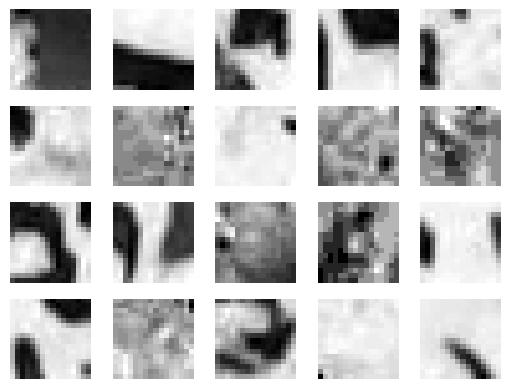

In [21]:
import matplotlib.pyplot as plt

# Select the first 20 patches
first_20_patches = patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()


In [22]:
import numpy as np

def normalize_for_contrast(patches):
    # Calculate the mean and variance along axis 0 (rows) since you want to apply it to 'patches.T'
    patches_mean = np.mean(patches, axis=0, keepdims=True)
    patches_variance = np.var(patches, axis=0, ddof=1, keepdims=True)
    
    # Normalize for contrast
    normalized_patches = (patches - patches_mean) / np.sqrt(patches_variance + 10)
    
    return normalized_patches

# Assuming 'patches' is a 2D array where each column is a patch
normalized_patches = normalize_for_contrast(patches)



In [23]:
normalized_patches.shape

(55000, 256)

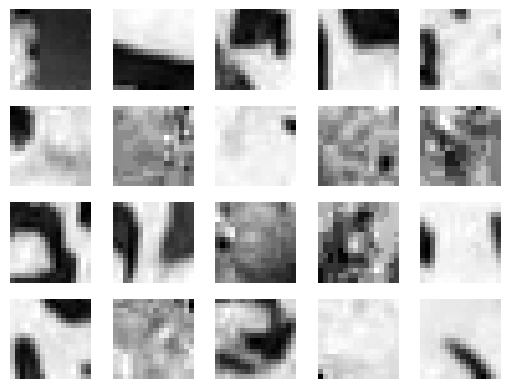

In [24]:
first_20_patches =normalized_patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()

In [25]:
def whiten_patches(patches):
    C = np.cov(patches, rowvar=False)
    M = np.mean(patches, axis=0)
    D, V = np.linalg.eigh(C)
    P = V @ np.diag(1 / np.sqrt(D + 0.1)) @ V.T
    whitened_patches = (patches - M) @ P
    return whitened_patches

# Whitening the normalized patches
whitened_normalized_patches = whiten_patches(normalized_patches)


In [26]:
whitened_normalized_patches.shape

(55000, 256)

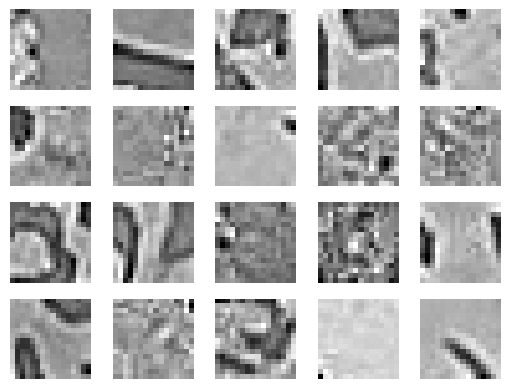

In [27]:
first_20_patches = whitened_normalized_patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()

In [28]:
whitened_normalized_patches.shape

(55000, 256)

In [29]:
def run_kmeans(X, k, iterations):
    x2 = np.sum(X**2, axis=1)
    centroids = np.random.randn(k, X.shape[1]) * 0.1
    BATCH_SIZE = 1000

    for itr in range(1, iterations + 1):
        print(f'K-means iteration {itr} / {iterations}')

        c2 = 0.5 * np.sum(centroids**2, axis=1)

        summation = np.zeros((k, X.shape[1]))
        counts = np.zeros(k)
        loss = 0

        for i in range(0, X.shape[0], BATCH_SIZE):
            lastIndex = min(i + BATCH_SIZE, X.shape[0])
            m = lastIndex - i

            val = np.argmax(np.dot(centroids, X[i:lastIndex, :].T) - c2, axis=0)
            loss += np.sum(0.5 * x2[i:lastIndex] - val)

            S = np.zeros((m, k))
            for j in range(m):
                S[j, val[j]] = 1

            summation += np.dot(S.T, X[i:lastIndex, :])
            counts += np.sum(S, axis=0)

        centroids = summation / counts[:, np.newaxis]

        # Zap empty centroids to avoid introducing NaNs
        bad_indices = np.where(counts == 0)[0]
        centroids[bad_indices, :] = 0

    return centroids


In [34]:
def show_centroids(centroids, H, W):
    if W is None:
        W = H

    N = centroids.shape[1] // (H * W)
    assert N == 3 or N == 1  # Color and gray images

    K = centroids.shape[0]
    COLS = round(np.sqrt(K))
    ROWS = np.ceil(K / COLS)
    COUNT = COLS * ROWS

    image = np.ones((int(ROWS) * (H + 1), int(COLS) * (W + 1), N)) * 255

    for i in range(centroids.shape[0]):
        r = i // COLS
        c = i % COLS
        image[r * (H + 1): (r + 1) * (H + 1) - 1, c * (W + 1): (c + 1) * (W + 1) - 1, :] = centroids[i, :W * H * N].reshape(H, W, N)

    mn = -1.5
    mx = 1.5
    image = (image - mn) / (mx - mn)

    plt.imshow(image)
    plt.show()



In [32]:
num_centroids = 1000
num_iterations = 50
# Run K-means clustering
centroids = run_kmeans(whitened_normalized_patches, num_centroids, num_iterations)




K-means iteration 1 / 50
K-means iteration 2 / 50


/tmp/ipykernel_895786/1795799017.py:29: RuntimeWarning: invalid value encountered in divide
  centroids = summation / counts[:, np.newaxis]


K-means iteration 3 / 50
K-means iteration 4 / 50
K-means iteration 5 / 50
K-means iteration 6 / 50
K-means iteration 7 / 50
K-means iteration 8 / 50
K-means iteration 9 / 50
K-means iteration 10 / 50
K-means iteration 11 / 50
K-means iteration 12 / 50
K-means iteration 13 / 50
K-means iteration 14 / 50
K-means iteration 15 / 50
K-means iteration 16 / 50
K-means iteration 17 / 50
K-means iteration 18 / 50
K-means iteration 19 / 50
K-means iteration 20 / 50
K-means iteration 21 / 50
K-means iteration 22 / 50
K-means iteration 23 / 50
K-means iteration 24 / 50
K-means iteration 25 / 50
K-means iteration 26 / 50
K-means iteration 27 / 50
K-means iteration 28 / 50
K-means iteration 29 / 50
K-means iteration 30 / 50
K-means iteration 31 / 50
K-means iteration 32 / 50
K-means iteration 33 / 50
K-means iteration 34 / 50
K-means iteration 35 / 50
K-means iteration 36 / 50
K-means iteration 37 / 50
K-means iteration 38 / 50
K-means iteration 39 / 50
K-means iteration 40 / 50
K-means iteration 4

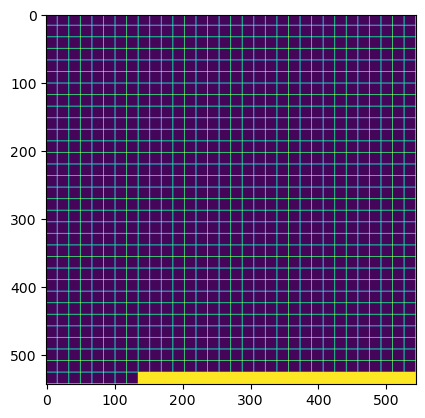

In [35]:
# Display the centroids
show_centroids(centroids, 16,16)

In [36]:
centroids.shape

(1000, 256)

In [38]:
centroids[1]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.